In [1]:
import os
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
    os.chdir(Path(os.getcwd())/'..') # ew

import numpy as np
from tqdm.notebook import tqdm
import torch

# import minimax scaler from scikit-learn
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
from response.maps import  collect_posterior_means
from deep_traffic_generation.cvae import CVAE
from deep_traffic_generation.core.datasets import TSDataset
from traffic.core import Traffic

# add automatic reloading of modules
%load_ext autoreload
%autoreload 2

device = "cpu"

# seed everything
np.random.seed(32)
torch.manual_seed(32)
torch.cuda.manual_seed(32)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Loading data and model

In [2]:
dataset = np.load(f'data/symbols/augmented_symbols.npy', allow_pickle=True)
dataset = TSDataset(np.swapaxes(dataset, 1, 2), None)

In [3]:
path_tcvae = r"models\symbols.ckpt"
model = CVAE.load_from_checkpoint(path_tcvae, dataset_params=dataset.parameters).eval().to(device)

Collect posterior means

In [4]:
# Collect posterior samples for the histogram
batch_size = 512
Z = collect_posterior_means(model, dataset, device=device, batch_size=batch_size, pbar=tqdm).detach().cpu()

  0%|          | 0/1100 [00:00<?, ?it/s]

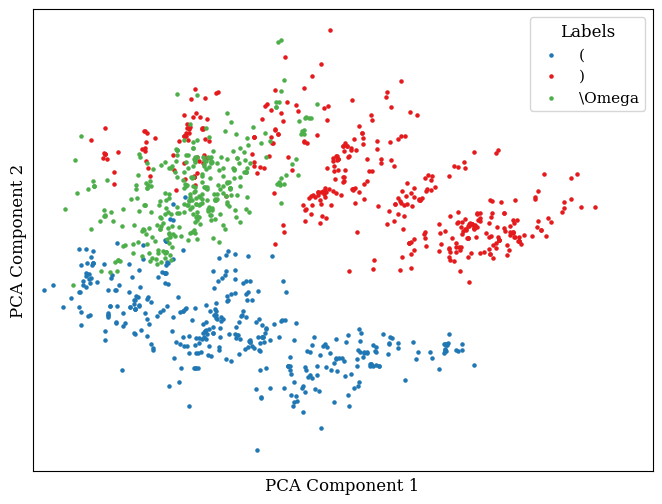

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load data and labels
labels = np.load('data/symbols/augmented_labels.npy', allow_pickle=True)

# Set Matplotlib parameters for LaTeX compatibility
correction = 2
plt.rcParams.update({
    "text.usetex": False,  # Set to True if using LaTeX
    "font.family": "serif",
    "font.size": 10 + correction,
    "axes.titlesize": 11 + correction,
    "axes.labelsize": 10 + correction,
    "xtick.labelsize": 9 + correction,
    "ytick.labelsize": 9 + correction,
    "legend.fontsize": 9 + correction ,
})

# Perform PCA
Z_pca = PCA(n_components=2).fit_transform(Z)

# Define color mapping for labels
color_map = {
    0: '#000000',
    '(': '#1f77b4',
    ')': '#e41a1c',
    '\Omega': '#4daf4a',
}

# Plot PCA results
plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)

for label in unique_labels:
    idx = np.where(labels == label)
    color = color_map.get(label, '#000000')  # Default to black if label not found
    plt.scatter(Z_pca[idx, 0], Z_pca[idx, 1], label=label, color=color, alpha=1, s=5)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Remove grid and axis numbers
plt.grid(False)
plt.xticks([])
plt.yticks([])

plt.xlim(-5, 8)

plt.legend(title="Labels")


plt.show()
